In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.metrics import SCORERS
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#from lightgbm import LGBMRegressor
#import xgboost as xgb


#next: try boosting algorithms, and gridsearch aiming to improve SVC or even better reduces forests overfitting
#download 2022 squads to make predictions

In [51]:
#loading data and retaining only significant columns
df=pd.read_csv('NBA_Pts.csv', sep=';', decimal=',')
df=df[df['Team2']!='nok'][['Season_endyear', 'Player', 'Pos', 'Age', 'G', 'PTS', 'Team2']]
df.head(5)

,Season_endyear,Player,Pos,Age,G,PTS,Team2
0,2010,Arron Afflalo,SG,24,82,8.829268,DEN
1,2010,Alexis Ajinça,C,21,6,1.666667,CHO
2,2010,LaMarcus Aldridge,PF,24,78,17.858974,POR
3,2010,Joe Alexander,SF,23,8,0.500000,CHI
4,2010,Malik Allen,PF,31,51,2.058824,DEN


In [52]:
#searching for serious injuries through game tresholds

df_games=df.copy()
#for year in range(5):
for year in range(3):
    df_games['G-'+str(year+1)]=(df_games.sort_values(by=['Season_endyear'], ascending=True).groupby(['Player'])['G'].shift(year+1))

df_games['pts_injury_adjusted']=np.where(df_games['G']/df_games['G-1']<0.5, 1, 0)
#df_games['std']=df_games[['G-1','G-2','G-3','G-4','G-5']].std(axis=1)
#df_games['hist']=((df_games['G']-df_games['mean'])/df_games['mean'])
#df_games['low_tres']=df_games['mean']-df_games['std']
#df_games[df_games['Player']=='Stephen Curry']
#df_games[df_games['Player']=='Kawhi Leonard']
#df_games[df_games['hist']<1]['hist'].hist(bins=50)
df_games

,Season_endyear,Player,Pos,Age,G,PTS,Team2,G-1,G-2,G-3,pts_injury_adjusted
0,2010,Arron Afflalo,SG,24,82,8.829268,DEN,74.0,NaN,NaN,0
1,2010,Alexis Ajinça,C,21,6,1.666667,CHO,31.0,NaN,NaN,1
2,2010,LaMarcus Aldridge,PF,24,78,17.858974,POR,81.0,NaN,NaN,0
3,2010,Joe Alexander,SF,23,8,0.500000,CHI,59.0,NaN,NaN,1
4,2010,Malik Allen,PF,31,51,2.058824,DEN,49.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
8067,2011,Dorell Wright,SF,25,82,16.390244,GSW,72.0,6.0,NaN,0
8068,2011,Julian Wright,SF,23,52,3.615385,TOR,68.0,54.0,NaN,0
8069,2011,Nick Young,SG,25,64,17.421875,WAS,74.0,82.0,NaN,0
8070,2011,Sam Young,SF,25,78,7.333333,MEM,80.0,NaN,NaN,0


In [53]:
#creating last 5 years data


#for year in range(5):
for year in range(3):
    df['PTS_year-'+str(year+1)]=(df.sort_values(by=['Season_endyear'], ascending=True).groupby(['Player'])['PTS'].shift(year+1))

"""
#test - adjusting for injuries
df['PTS_y']=df['PTS']
df2=df.merge(df_games[['Season_endyear', 'Player', 'pts_injury_adjusted']], on=['Season_endyear', 'Player'])
#df2['mean']=df2[['PTS_year-1', 'PTS_year-2', 'PTS_year-3', 'PTS_year-4', 'PTS_year-5']].mean(axis=1)
df2['mean']=df2[['PTS_year-1', 'PTS_year-2', 'PTS_year-3']].mean(axis=1)
df2['PTS']=np.where(df2['pts_injury_adjusted']==0, df2['PTS'], df2['mean'])
#for year in range(5):
for year in range(3):
    df2['PTS_year-'+str(year+1)]=(df2.sort_values(by=['Season_endyear'], ascending=True).groupby(['Player'])['PTS'].shift(year+1))

df=df2.drop(['pts_injury_adjusted', 'mean'], axis=1)
#df2[df2['Player']=='Stephen Curry']
df[df['Player']=='Stephen Curry']
"""
df[df['Player']=='Stephen Curry']

,Season_endyear,Player,Pos,Age,G,PTS,Team2,PTS_year-1,PTS_year-2,PTS_year-3
120,2010,Stephen Curry,PG,21,80,17.487500,GSW,NaN,NaN,NaN
1311,2021,Stephen Curry,PG,32,63,32.000000,GSW,20.800000,27.300000,26.400000
2023,2020,Stephen Curry,PG,31,5,20.800000,GSW,27.300000,26.400000,25.303797
2675,2019,Stephen Curry,PG,30,69,27.300000,GSW,26.400000,25.303797,30.063291
3370,2018,Stephen Curry,PG,29,51,26.400000,GSW,25.303797,30.063291,23.750000
4008,2017,Stephen Curry,PG,28,79,25.303797,GSW,30.063291,23.750000,24.012821
4599,2016,Stephen Curry,PG,27,79,30.063291,GSW,23.750000,24.012821,22.897436
5196,2015,Stephen Curry,PG,26,80,23.750000,GSW,24.012821,22.897436,14.730769
5861,2014,Stephen Curry,PG,25,78,24.012821,GSW,22.897436,14.730769,18.554054
6442,2013,Stephen Curry,PG,24,78,22.897436,GSW,14.730769,18.554054,17.487500


In [73]:
#creating the yearly current team past total ppg

pts=[5, 10, 15, 20, 25, 30]
#creating player teams bins
df_bins=df[['Season_endyear', 'Team2', 'PTS']].copy()
for i in range(len(pts)):
    if i<len(pts)-1:
        df_bins['bin_'+str(pts[i])]=np.where((df_bins['PTS']>=pts[i]) & (df_bins['PTS']<pts[i+1]),1,0)
    else:
        df_bins['bin_'+str(pts[i])]=np.where(df_bins['PTS']>=pts[i],1,0)
df_bins=df_bins.groupby(['Season_endyear', 'Team2']).sum().reset_index().drop('PTS', axis=1)

#for year in range(5):
for year in range(3):
    for bins in pts:
        df_bins['bin_'+str(bins)+'-'+str(year+1)]=(df_bins.sort_values(by=['Season_endyear'], ascending=True).groupby(['Team2'])['bin_'+str(bins)].shift(year+1))


#creating year-1 bins (bins of this seasons players last season)
df_bins2=df[['Season_endyear', 'Team2', 'PTS_year-1']].copy()
for i in range(len(pts)):
    if i<len(pts)-1:
        df_bins2['bin_'+str(pts[i])]=np.where((df_bins2['PTS_year-1']>=pts[i]) & (df_bins2['PTS_year-1']<pts[i+1]),1,0)
    else:
        df_bins2['bin_'+str(pts[i])]=np.where(df_bins2['PTS_year-1']>=pts[i],1,0)
df_bins2=df_bins2.groupby(['Season_endyear', 'Team2']).sum().reset_index().drop('PTS_year-1', axis=1)

#########################################repeating process for position
"""
#creating player teams bins
df_bins_pos=df[['Season_endyear', 'Team2','Pos', 'PTS']].copy()
for pts in [5, 10, 15, 20, 25, 30]:
    df_bins_pos['bin_'+str(pts)]=np.where(df_bins_pos['PTS']>=pts,1,0)
df_bins_pos=df_bins_pos.groupby(['Season_endyear', 'Team2', 'Pos']).sum().reset_index().drop('PTS', axis=1)

#for year in range(5):
for year in range(3):
    for bins in [5, 10, 15, 20, 25, 30]:
        df_bins_pos['bin_'+str(bins)+'-'+str(year+1)]=(df_bins_pos.sort_values(by=['Season_endyear'], ascending=True).groupby(['Team2', 'Pos'])['bin_'+str(bins)].shift(year+1))


#creating year-1 bins (bins of this seasons players last season)
df_bins2_pos=df[['Season_endyear', 'Team2', 'Pos', 'PTS_year-1']].copy()
for pts in [5, 10, 15, 20, 25, 30]:
    df_bins2_pos['bin_'+str(pts)]=np.where(df_bins2_pos['PTS_year-1']>=pts,1,0)
df_bins2_pos=df_bins2_pos.groupby(['Season_endyear', 'Team2', 'Pos']).sum().reset_index().drop('PTS_year-1', axis=1)
"""

###############################################merging in the final dataframe
df_stats=df.merge(df_bins, on=['Season_endyear', 'Team2'], suffixes=('','_teambins'))
df_stats=df_stats.merge(df_bins2, on=['Season_endyear', 'Team2'], suffixes=('','_lastbins'))
#df_stats=df_stats.merge(df_bins_pos, on=['Season_endyear', 'Team2', 'Pos'], suffixes=('','_teamposbins'))
#df_stats=df_stats.merge(df_bins2_pos, on=['Season_endyear', 'Team2', 'Pos'], suffixes=('','_lastposbins'))
df_stats.head(5)

#drop season prior to 2013 for lack of data
df_stats=df_stats[df_stats['Season_endyear']>2013]


#replacing NA with 0. Usually it will mean a new player, sometimes can account for long-term injuries. But let's see how it goes

df_stats=df_stats.fillna(0)
df_stats[df_stats['Player']=='Stephen Curry']

,Season_endyear,Player,Pos,Age,G,PTS,Team2,PTS_year-1,PTS_year-2,PTS_year-3,bin_5,bin_10,bin_15,bin_20,bin_25,bin_30,bin_5-1,bin_10-1,bin_15-1,bin_20-1,bin_25-1,bin_30-1,bin_5-2,bin_10-2,bin_15-2,bin_20-2,bin_25-2,bin_30-2,bin_5-3,bin_10-3,bin_15-3,bin_20-3,bin_25-3,bin_30-3,bin_5_lastbins,bin_10_lastbins,bin_15_lastbins,bin_20_lastbins,bin_25_lastbins,bin_30_lastbins
1223,2021,Stephen Curry,PG,32,63,32.000000,GSW,20.800000,27.300000,26.400000,8,2,2,0,0,1,9.0,4.0,1.0,2.0,0.0,0.0,6.0,0.0,1.0,1.0,2.0,0.0,7.0,1.0,0.0,1.0,2.0,0.0,6,3,1,2,0,0
1816,2020,Stephen Curry,PG,31,5,20.800000,GSW,27.300000,26.400000,25.303797,9,4,1,2,0,0,6.0,0.0,1.0,1.0,2.0,0.0,7.0,1.0,0.0,1.0,2.0,0.0,5.0,1.0,0.0,1.0,2.0,0.0,7,1,0,1,1,0
2406,2019,Stephen Curry,PG,30,69,27.300000,GSW,26.400000,25.303797,30.063291,6,0,1,1,2,0,7.0,1.0,0.0,1.0,2.0,0.0,5.0,1.0,0.0,1.0,2.0,0.0,6.0,2.0,0.0,1.0,0.0,1.0,4,2,0,1,3,0
2884,2018,Stephen Curry,PG,29,51,26.400000,GSW,25.303797,30.063291,23.750000,7,1,0,1,2,0,5.0,1.0,0.0,1.0,2.0,0.0,6.0,2.0,0.0,1.0,0.0,1.0,5.0,3.0,0.0,2.0,0.0,0.0,6,2,0,1,2,0
3498,2017,Stephen Curry,PG,28,79,25.303797,GSW,30.063291,23.750000,24.012821,5,1,0,1,2,0,6.0,2.0,0.0,1.0,0.0,1.0,5.0,3.0,0.0,2.0,0.0,0.0,8.0,1.0,2.0,1.0,0.0,0.0,5,1,0,1,1,1
3787,2016,Stephen Curry,PG,27,79,30.063291,GSW,23.750000,24.012821,22.897436,6,2,0,1,0,1,5.0,3.0,0.0,2.0,0.0,0.0,8.0,1.0,2.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0,0.0,0.0,5,3,0,2,0,0
4286,2015,Stephen Curry,PG,26,80,23.750000,GSW,24.012821,22.897436,14.730769,5,3,0,2,0,0,8.0,1.0,2.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0,0.0,0.0,4.0,4.0,0.0,2.0,0.0,0.0,7,0,2,1,0,0
4723,2014,Stephen Curry,PG,25,78,24.012821,GSW,22.897436,14.730769,18.554054,8,1,2,1,0,0,3.0,2.0,2.0,1.0,0.0,0.0,4.0,4.0,0.0,2.0,0.0,0.0,2.0,0.0,3.0,1.0,0.0,0.0,5,2,2,1,0,0


In [74]:

#test - adjusting for injuries - which should only be done after the team aggregated stats. Therefore, it changed place 
df_stats['PTS_y']=df_stats['PTS']
df2=df_stats.merge(df_games[['Season_endyear', 'Player', 'pts_injury_adjusted']], on=['Season_endyear', 'Player'])
df2['mean']=df2[['PTS_year-1', 'PTS_year-2', 'PTS_year-3']].mean(axis=1)
#df2['mean']=df2[['PTS_year-1', 'PTS_year-2', 'PTS_year-3']].mean(axis=1)
df2['PTS']=np.where(df2['pts_injury_adjusted']==0, df2['PTS'], df2['mean'])
#for year in range(5):
for year in range(5):
    df2['PTS_year-'+str(year+1)]=(df2.sort_values(by=['Season_endyear'], ascending=True).groupby(['Player'])['PTS'].shift(year+1))

df_stats2=df_stats.drop(['PTS', 'PTS_y', 'PTS_year-1', 'PTS_year-2', 'PTS_year-3'], axis=1).merge(df2[['Season_endyear', 'Player', 'PTS', 'PTS_y', 'PTS_year-1', 'PTS_year-2', 'PTS_year-3']], on=['Season_endyear', 'Player'])
df_stats=df_stats2
df_stats=df_stats.fillna(0)
df_stats=df_stats[df_stats['PTS_year-1']>0]

#rank in team with last season's points
df_rank=df_stats.copy()
df_rank['rank']=df_rank.groupby(["Season_endyear", 'Team2'])["PTS_year-1"].rank("dense", ascending=False)
df_stats=df_stats.merge(df_rank[["Season_endyear", 'Player', 'rank']], on=["Season_endyear", 'Player'])

df_stats=pd.get_dummies(df_stats, columns=['Pos'])

df2[df2['Player']=='Stephen Curry']
df_stats[df_stats['Player']=='Stephen Curry']


,Season_endyear,Player,Age,G,Team2,bin_5,bin_10,bin_15,bin_20,bin_25,bin_30,bin_5-1,bin_10-1,bin_15-1,bin_20-1,bin_25-1,bin_30-1,bin_5-2,bin_10-2,bin_15-2,bin_20-2,...,PTS,PTS_y,PTS_year-1,PTS_year-2,PTS_year-3,rank,Pos_C,Pos_C-PF,Pos_PF,Pos_PF-C,Pos_PF-SF,Pos_PG,Pos_PG-SG,Pos_SF,Pos_SF-C,Pos_SF-PF,Pos_SF-SG,Pos_SG,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF
277,2021,Stephen Curry,32,63,GSW,8,2,2,0,0,1,9.0,4.0,1.0,2.0,0.0,0.0,6.0,0.0,1.0,1.0,...,32.000000,32.000000,26.334599,27.300000,26.400000,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
753,2020,Stephen Curry,31,5,GSW,9,4,1,2,0,0,6.0,0.0,1.0,1.0,2.0,0.0,7.0,1.0,0.0,1.0,...,26.334599,20.800000,27.300000,26.400000,25.303797,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1212,2019,Stephen Curry,30,69,GSW,6,0,1,1,2,0,7.0,1.0,0.0,1.0,2.0,0.0,5.0,1.0,0.0,1.0,...,27.300000,27.300000,26.400000,25.303797,30.063291,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1585,2018,Stephen Curry,29,51,GSW,7,1,0,1,2,0,5.0,1.0,0.0,1.0,2.0,0.0,6.0,2.0,0.0,1.0,...,26.400000,26.400000,25.303797,30.063291,23.750000,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2075,2017,Stephen Curry,28,79,GSW,5,1,0,1,2,0,6.0,2.0,0.0,1.0,0.0,1.0,5.0,3.0,0.0,2.0,...,25.303797,25.303797,30.063291,23.750000,24.012821,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2321,2016,Stephen Curry,27,79,GSW,6,2,0,1,0,1,5.0,3.0,0.0,2.0,0.0,0.0,8.0,1.0,2.0,1.0,...,30.063291,30.063291,23.750000,24.012821,0.000000,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2726,2015,Stephen Curry,26,80,GSW,5,3,0,2,0,0,8.0,1.0,2.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0,...,23.750000,23.750000,24.012821,0.000000,0.000000,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [85]:
#separating train and test sets
df_stats['variation']=df_stats['PTS_y']-df_stats['PTS_year-1']

#X=df_stats[df_stats['Season_endyear']<2021].drop(['Season_endyear', 'Player', 'G', 'Team2', 'PTS', 'PTS_y', 'bin_5', 'bin_10', 'bin_15', 'bin_20', 'bin_25', 'bin_30', 'bin_5_teamposbins', 'bin_10_teamposbins', 'bin_15_teamposbins', 'bin_20_teamposbins', 'bin_25_teamposbins', 'bin_30_teamposbins'], axis=1)
X=df_stats[df_stats['Season_endyear']<2021].drop(['variation', 'Season_endyear', 'Player', 'G', 'Team2', 'PTS', 'PTS_y', 'bin_5', 'bin_10', 'bin_15', 'bin_20', 'bin_25', 'bin_30'], axis=1)
#X_oot=df_stats[df_stats['Season_endyear']==2021].drop(['Season_endyear', 'Player', 'G', 'Team2', 'PTS', 'PTS_y', 'bin_5', 'bin_10', 'bin_15', 'bin_20', 'bin_25', 'bin_30', 'bin_5_teamposbins', 'bin_10_teamposbins', 'bin_15_teamposbins', 'bin_20_teamposbins', 'bin_25_teamposbins', 'bin_30_teamposbins'], axis=1)
X_oot=df_stats[df_stats['Season_endyear']==2021].drop(['variation', 'Season_endyear', 'Player', 'G', 'Team2', 'PTS', 'PTS_y', 'bin_5', 'bin_10', 'bin_15', 'bin_20', 'bin_25', 'bin_30'], axis=1)
y=df_stats[df_stats['Season_endyear']<2021]['variation']
y_oot=df_stats[df_stats['Season_endyear']==2021]['variation']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)
#X_train, X_test, y_train, y_test = train_test_split(X[X['PTS_year-1']>0], y[X['PTS_year-1']>0], test_size=0.33, random_state=8)



In [86]:
#training and evaluating the models
lr=LinearRegression()
sv=SVR()
rf=RandomForestRegressor()
#lgbm=lightgbm.LGBMRegressor()

r2=[]
mse=[]
models=[]
dataset=[]

for model in [rf]:
    #model.fit(X_train, y_train)
    model.fit(X,y)
    r2.append(r2_score(y_train, model.predict(X_train)))
    #r2.append(r2_score(y_test, model.predict(X_test)))
    r2.append(r2_score(y_oot, model.predict(X_oot)))
    mse.append(mean_squared_error(y_train, model.predict(X_train)))
    #mse.append(mean_squared_error(y_test, model.predict(X_test)))
    mse.append(mean_squared_error(y_oot, model.predict(X_oot)))
    dataset.append(['train', 'test', 'oot'])
    models.append([str(model),str(model),str(model)])


In [87]:
#evaluating results
r2

[0.8781346534634944, 0.13506029166228706]

In [88]:
#evaluating results
mse

[1.304834632900953, 9.748759778950783]

In [90]:
#checking 2021 predictions vs. actual

df_check=df_stats[df_stats['Season_endyear']==2021][['Player', 'variation']].copy()
df_check['prediction']=rf.predict(X_oot)
#df_check['error']=df_check['PTS_y']-df_check['prediction']
df_check['error']=df_check['variation']-df_check['prediction']
#df_check.sort_values(by=['prediction'], ascending=False).head(10)
df_check.sort_values(by=['error'], ascending=False).head(10)

,Player,variation,prediction,error
388,Khyri Thomas,15.633333,3.101647,12.531686
321,Jerami Grant,10.300000,0.863981,9.436019
259,Michael Porter Jr.,9.700000,1.603873,8.096127
151,Chris Boucher,7.000000,-0.935987,7.935987
392,Christian Wood,7.900000,0.277730,7.622270
277,Stephen Curry,5.665401,-1.834596,7.499996
412,Jaylen Brown,4.400000,-2.649410,7.049410
117,Nikola Vučević,3.800000,-3.209229,7.009229
147,Gary Trent Jr.,6.400000,-0.553827,6.953827
290,Darius Bazley,8.100000,1.296027,6.803973


In [81]:
#checking if we can detect big variations
df_check2=df_stats[df_stats['Season_endyear']==2021][['Player', 'PTS_y', 'PTS_year-1']].copy()
df_check2['prediction']=rf.predict(X_oot)
df_check2['error']=df_check2['PTS_y']-df_check2['prediction']
df_check2['var']=df_check2['PTS_y']-df_check2['PTS_year-1']
#df_check.sort_values(by=['prediction'], ascending=False).head(10)
df_check2=df_check2[df_check2['PTS_year-1']>0]
df_check2.sort_values(by=['var'], ascending=True).head(10)

,Player,PTS_y,PTS_year-1,prediction,error,var
396,Spencer Dinwiddie,6.7,20.600000,20.881695,-14.181695,-13.900000
399,Blake Griffin,11.0,22.491257,19.078289,-8.078289,-11.491257
400,James Harden,24.6,34.300000,28.477180,-3.877180,-9.700000
419,Jabari Parker,5.5,14.000000,14.195057,-8.695057,-8.500000
138,Rodney Hood,4.5,12.859322,11.386504,-6.886504,-8.359322
38,J.J. Redick,7.4,15.300000,14.127216,-6.727216,-7.900000
378,DeMarcus Cousins,8.9,16.300000,15.986821,-7.086821,-7.400000
222,Hassan Whiteside,8.1,15.500000,13.615198,-5.515198,-7.400000
273,Lou Williams,11.3,18.200000,15.999669,-4.699669,-6.900000
221,Glenn Robinson III,5.3,11.700000,10.694151,-5.394151,-6.400000


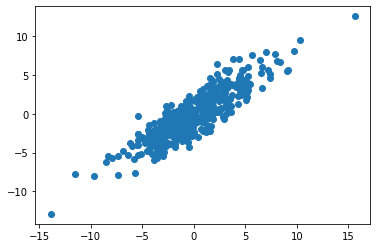

In [92]:
#plt.scatter(df_check2['var'], df_check2['error'])
plt.scatter(df_check['variation'], df_check['error'])
#plt.scatter(X['rank'], y)

In [93]:
df_check[(df_check['Player'] == 'Stephen Curry') | (df_check['Player'] == 'Anthony Davis') | (df_check['Player'] == 'Russell Westbrook')| (df_check['Player'] == 'Bradley Beal')]


,Player,variation,prediction,error
123,Anthony Davis,-4.300000,-1.883949,-2.416051
176,Bradley Beal,0.800000,0.503214,0.296786
192,Russell Westbrook,-5.000000,-1.897644,-3.102356
277,Stephen Curry,5.665401,-1.834596,7.499996


In [94]:
df_view=df_stats[(df_stats['Season_endyear'] == 2021) & ((df_stats['Player'] == 'Stephen Curry') | (df_stats['Player'] == 'Anthony Davis') | (df_stats['Player'] == 'Russell Westbrook')| (df_stats['Player'] == 'Bradley Beal')| (df_stats['Player'] == 'Spencer Dinwiddie') )]
df_view.to_csv('analysis.csv')
pd.set_option('display.max_columns', 42)
df_view


,Season_endyear,Player,Age,G,Team2,bin_5,bin_10,bin_15,bin_20,bin_25,bin_30,bin_5-1,bin_10-1,bin_15-1,bin_20-1,bin_25-1,bin_30-1,bin_5-2,bin_10-2,bin_15-2,bin_20-2,...,PTS_y,PTS_year-1,PTS_year-2,PTS_year-3,rank,Pos_C,Pos_C-PF,Pos_PF,Pos_PF-C,Pos_PF-SF,Pos_PG,Pos_PG-SG,Pos_SF,Pos_SF-C,Pos_SF-PF,Pos_SF-SG,Pos_SG,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF,variation
123,2021,Anthony Davis,27,36,LAL,5,2,1,1,1,0,10.0,2.0,0.0,0.0,2.0,0.0,8.0,2.0,2.0,0.0,...,21.8,26.100000,25.9,28.1,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-4.300000
176,2021,Bradley Beal,27,60,WAS,7,3,0,1,0,1,6.0,6.0,1.0,0.0,0.0,1.0,6.0,6.0,0.0,1.0,...,31.3,30.500000,25.6,22.6,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.800000
192,2021,Russell Westbrook,32,65,WAS,7,3,0,1,0,1,6.0,6.0,1.0,0.0,0.0,1.0,6.0,6.0,0.0,1.0,...,22.2,27.200000,22.9,25.4,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-5.000000
277,2021,Stephen Curry,32,63,GSW,8,2,2,0,0,1,9.0,4.0,1.0,2.0,0.0,0.0,6.0,0.0,1.0,1.0,...,32.0,26.334599,27.3,26.4,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5.665401
396,2021,Spencer Dinwiddie,27,3,BRK,9,3,0,1,2,0,7.0,4.0,1.0,1.0,1.0,0.0,6.0,4.0,1.0,1.0,...,6.7,20.600000,16.8,12.6,5.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-13.900000


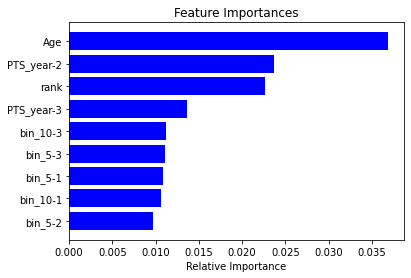

In [84]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
indices=indices[-10:-1]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Optimal number of features : 60


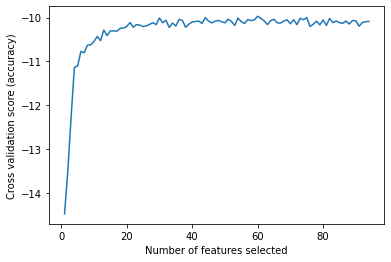

In [48]:
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
rff = RandomForestRegressor()
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=rff, step=1, cv=3,
              scoring='neg_mean_squared_error',
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [49]:
rfecv.grid_scores_

array([-14.48294278, -13.4988475 , -12.28277785, -11.14050041,
       -11.1009539 , -10.77231926, -10.80387302, -10.62917305,
       -10.62213988, -10.54414542, -10.42942522, -10.52866688,
       -10.28412723, -10.40928215, -10.30220084, -10.30363185,
       -10.30890035, -10.24626051, -10.23820018, -10.20204425,
       -10.11347338, -10.21818413, -10.15849577, -10.17174292,
       -10.20331995, -10.18649312, -10.15474583, -10.11535208,
       -10.15940909, -10.00670435, -10.11769948, -10.06024206,
       -10.22586104, -10.12312657, -10.19318847, -10.03946304,
       -10.06393799, -10.21989349, -10.14991599, -10.09856882,
       -10.08915305, -10.07830925, -10.13090306, -10.00287293,
       -10.07892558, -10.12016252, -10.08148654, -10.06493622,
       -10.09291501, -10.11883463, -10.03698888, -10.08639657,
       -10.17998301, -10.00981357, -10.09263726, -10.13466939,
       -10.04335648, -10.06770902, -10.05075255,  -9.96827885,
       -10.0185314 , -10.07295772, -10.1587061 , -10.06

In [47]:
#from sklearn.feature_selection import RFE
#rfe = RFE(estimator=rff, n_features_to_select=8, step=1)
#rfe.fit(X, y)
#X.columns[rfe.get_support([])]
list(X.columns)

['Age',
 'bin_5-1',
 'bin_10-1',
 'bin_15-1',
 'bin_20-1',
 'bin_25-1',
 'bin_30-1',
 'bin_5-2',
 'bin_10-2',
 'bin_15-2',
 'bin_20-2',
 'bin_25-2',
 'bin_30-2',
 'bin_5-3',
 'bin_10-3',
 'bin_15-3',
 'bin_20-3',
 'bin_25-3',
 'bin_30-3',
 'bin_5-4',
 'bin_10-4',
 'bin_15-4',
 'bin_20-4',
 'bin_25-4',
 'bin_30-4',
 'bin_5-5',
 'bin_10-5',
 'bin_15-5',
 'bin_20-5',
 'bin_25-5',
 'bin_30-5',
 'bin_5_lastbins',
 'bin_10_lastbins',
 'bin_15_lastbins',
 'bin_20_lastbins',
 'bin_25_lastbins',
 'bin_30_lastbins',
 'bin_5-1_teamposbins',
 'bin_10-1_teamposbins',
 'bin_15-1_teamposbins',
 'bin_20-1_teamposbins',
 'bin_25-1_teamposbins',
 'bin_30-1_teamposbins',
 'bin_5-2_teamposbins',
 'bin_10-2_teamposbins',
 'bin_15-2_teamposbins',
 'bin_20-2_teamposbins',
 'bin_25-2_teamposbins',
 'bin_30-2_teamposbins',
 'bin_5-3_teamposbins',
 'bin_10-3_teamposbins',
 'bin_15-3_teamposbins',
 'bin_20-3_teamposbins',
 'bin_25-3_teamposbins',
 'bin_30-3_teamposbins',
 'bin_5-4_teamposbins',
 'bin_10-4_teampo